# 1. Исследовательский анализ данных

Dataset based on http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf

Загрузка данных:

In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('../datasets/appa-real-release/gt_train.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='../datasets/appa-real-release/train',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 133935 validated image filenames.


У нас имеется 7591 файлов. Посмотрим на их размерности. 

In [6]:
features, targets = next(train_gen_flow)
features.shape,\
targets.shape

((32, 224, 224, 3), (32,))

Картинки размерностью 224 на 224 (3 слоя). Первая размерность 32 из-за параметра batch_size при загрузке данных.

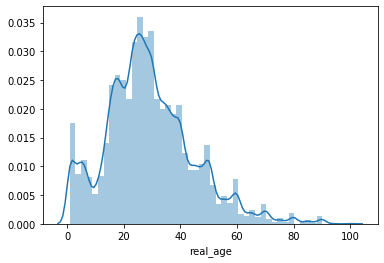

In [8]:
import seaborn as sns

sns.distplot(labels['real_age'])

*Распределение возрастов*. Основная концетрация изображений находится в промежутке 20-40 лет. 

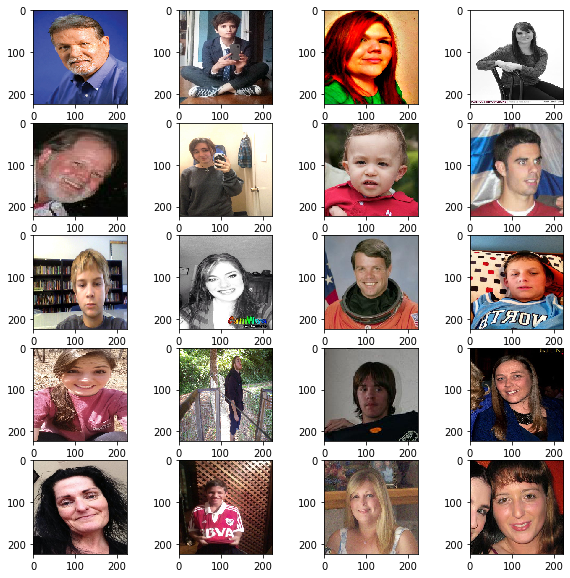

In [9]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.array(features[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

В нашем датасете имеются абсолютно различные изображения. Часть из них уже имеет некоторый наклон. 
Так как основное распределение возрастов от 20 до 40 лет, то модель может плохо отрабтать на людях вне этого распределения. 

# 2. Обучение модели

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def_path = '../datasets/appa-real-release/'

def load_train(path):
    labels = pd.read_csv(path + 'gt_train.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels[:50000],
            directory='../datasets/appa-real-release/train',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)
    return train_gen_flow


def load_test(path=None):
    labels = pd.read_csv(path + 'gt_test.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels[:10000],
            directory='../datasets/appa-real-release/test',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)
    return train_gen_flow
    


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights="imagenet", 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss="MAE", metrics=["mae"])
    return model


def train_model(
                model,
                train_data,
                test_data,
                batch_size=None,
                epochs=5,
                steps_per_epoch=None,
                validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1,
        shuffle=False,
    )

    return model


In [57]:
train = load_train(def_path)
test = load_test(def_path)

Found 50000 validated image filenames.
Found 10000 validated image filenames.


In [58]:
model = create_model(input_shape = (224,224,3))

In [60]:
#train_model(model, train, test, epochs = 8)

```
On test data from Ya.Praktikum datasets
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 72s - loss: 11.0476 - mae: 11.0490 - val_loss: 23.0873 - val_mae: 23.0871
Epoch 2/5
356/356 - 40s - loss: 7.1561 - mae: 7.1563 - val_loss: 11.3263 - val_mae: 11.3181
Epoch 3/5
356/356 - 40s - loss: 5.9365 - mae: 5.9371 - val_loss: 8.6682 - val_mae: 8.6631
Epoch 4/5
356/356 - 40s - loss: 5.3829 - mae: 5.3836 - val_loss: 9.5273 - val_mae: 9.5266
Epoch 5/5
356/356 - 40s - loss: 4.6333 - mae: 4.6332 - val_loss: 6.7825 - val_mae: 6.7874
```

# 3. Анализ обученной модели

Наша модель обучилась за 5 эпох до требуемой точности. Мы получили значение  MAE на валдиационной выборке 6.787. 

В процессе обучения наш Loss стабильно уменьшались.

В моделе использовалась следующая структура:


  optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer, loss="MAE", metrics=["mae"])

* Препроцессинг:
    * Стандартный rescale для значений [0-1]
    * Batch-size = 16
    * Для валидации используется 25 % значений
* Модель:
    * ResNet50 
    * Последний слой из 1 нейрона с активацией ReLU (задача регрессии)
    * Оптимизатор Adam с LR = 0.0001
    * Функция ошибки - MAE
    
Данная модель смогла предодолеть требуемый baseline.
    